<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/joel_deerwester_hw05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pyfda

# 60Hz notch filter

Design a 60Hz notch filter (all frequencies have unit gain except
60Hz). You can use filterDesigner at first, but then use matlab code
to design the filter. Test this with the signal stored in gamma.mat.
There is a variable called osc. The first channel has strong 60Hz
noise.

signal = osc(:,1);

- Apply the notch filter to this signal and show the spectrogram
before and after using the 'spectrogram' function. (2 graphs)
- Also show the magnitude, phase and impulse response (3 graphs).
- Also show the signal itself before and after filtering, in the same
graph (1 graph). So in total you will have 6 graphs.
- If you are using an IIR filter apply the filter using the 'sosfilt'
function. If you are using FIR filter, use the 'filter' function.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import signal, stats
# from scipy.linalg import toeplitz
# from scipy.optimize import minimize
from scipy.fft import fft, fftfreq
from scipy.signal import firwin2, filtfilt


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

import warnings

from tqdm import tqdm
# import pyfda

In [ ]:
def grab_file(filename):
    import requests
    import io

    PARENT = 'https://parralab.org/teaching/biomed-dsp/'
    FILENAME = filename
    FULLPATH = PARENT+FILENAME
    print(FULLPATH)

    response = requests.get(FULLPATH)
    data_stream = io.BytesIO(response.content)

    return data_stream


def grab_mat(mat_file):
    from scipy import io as sio

    data_stream = grab_file(mat_file)
    mat_contents = sio.loadmat(data_stream)
    print(mat_contents.keys())

    return mat_contents


def grab_wav(wav_file):
    from scipy import io as sio

    audio_bytes = grab_file(wav_file)
    fs, data = sio.wavfile.read(audio_bytes)

    return fs, data

In [ ]:
gamma = grab_mat('gamma.mat')

https://parralab.org/teaching/biomed-dsp/gamma.mat
dict_keys(['__header__', '__version__', '__globals__', 'osc', 'fs'])


In [ ]:
def process_osc(arr, a):
    arr = stats.zscore(arr, axis=1)
    return a*np.tanh(arr/a)


fs = gamma['fs'][0][0]
osc = gamma['osc'].T

# osc = process_osc(osc, 5)

In [ ]:
print(osc.shape)
print(fs)

(2, 10000)
2000


$H(z) = \frac{Y(z)}{X(z)} = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}$

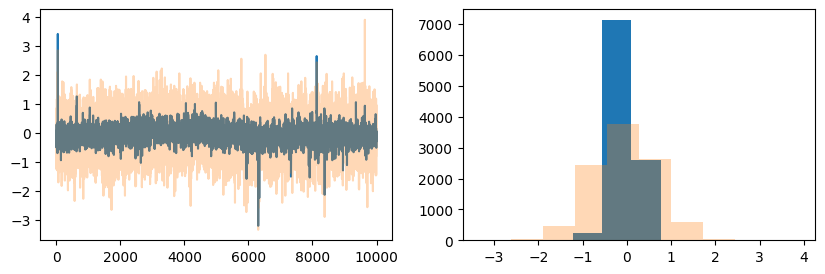

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(osc[0, :])
plt.plot(osc[1, :], alpha=0.3)  # noisier channel
plt.subplot(1,2,2)
plt.hist(osc[0, :])
plt.hist(osc[1, :], alpha=0.3)
plt.show()

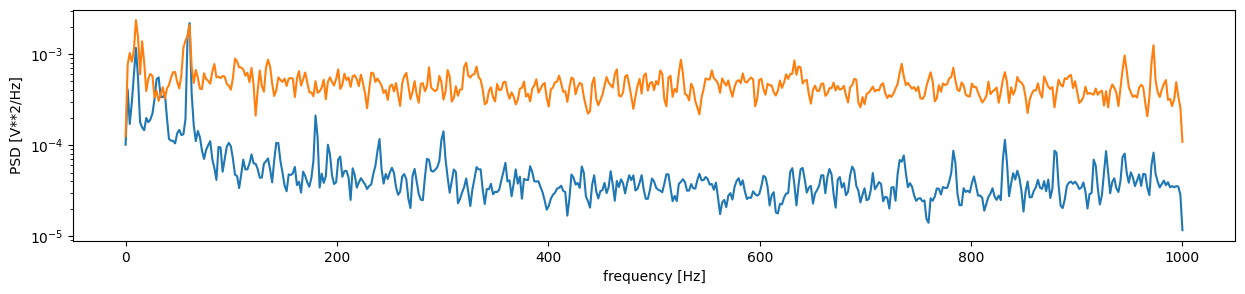

In [ ]:
# plot both channels - visualize noise and 60Hz spike
# only 60Hz, no harmonics

plt.figure(figsize=(15, 3))
for i in range(2):
    f, Pxx_den = signal.welch(osc[i, :], fs, nperseg=1024)
    plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Notch filter

In [ ]:
# signal = osc(:,1);
x = osc[0, :]

T = int(len(x)/fs)
N = int(T*fs)
n = np.arange(N)

dt = 1/fs
t = np.linspace(0, T, T*fs)

u = np.zeros(N)
# s = np.ones(N)
u[0] = 1

# 60Hz
f0 = 60.0
# quality factor ... try 30-60
Q = 30

# normalized freq
w0 = f0 / (fs / 2)
# iir coeffficients
b, a = signal.iirnotch(w0, Q)
print(f"b: {b}")
print(f"a: {a}")

sos = signal.tf2sos(b, a)
y = signal.sosfilt(sos, x)
print(f"len y:{len(y)}")

# h_notch = signal.lfilter(b, a, u)


h = signal.lfilter(b, a, u)
# s = signal.lfilter(b, a, s)
# y = signal.lfilter(b, a, x)

print(f"len h:{len(h)}")

b: [ 0.99686824 -1.95842192  0.99686824]
a: [ 1.         -1.95842192  0.99373647]
len y:10000
len h:10000


# Plot filtered vs original signal

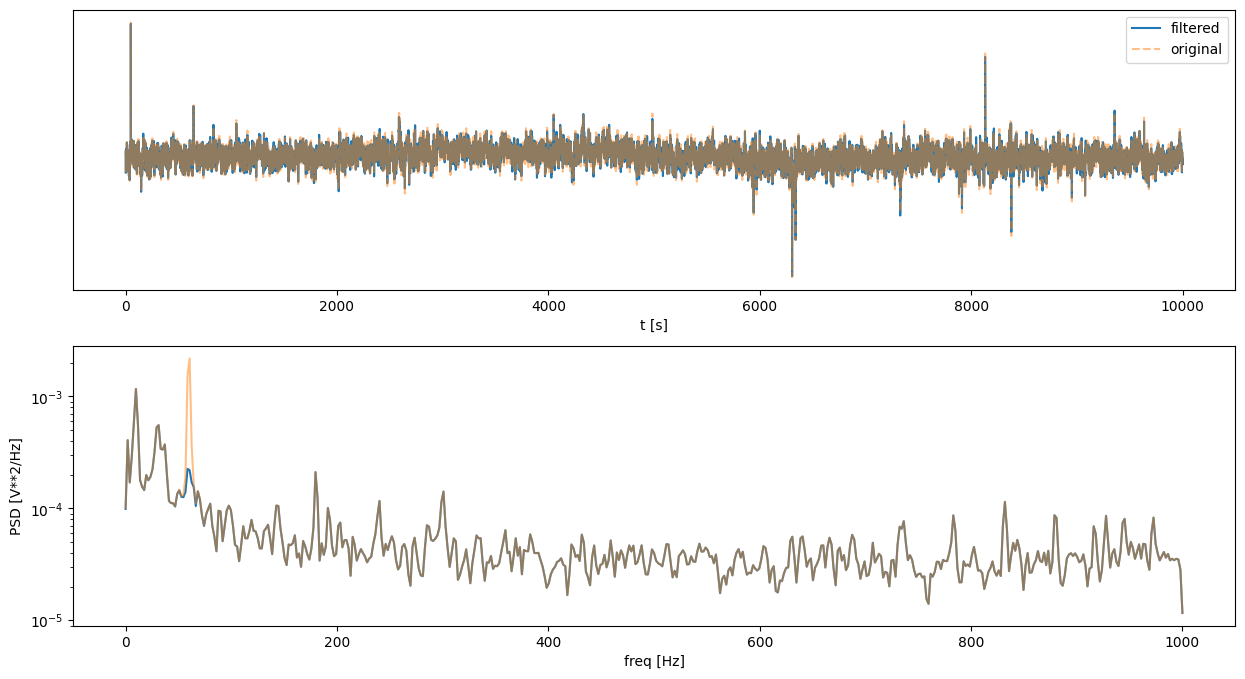

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(y, label="filtered")
plt.plot(x, label="original", ls='--', alpha=0.5)
plt.xlabel('t [s]')
plt.yticks([])
plt.legend()
# plt.show()

plt.subplot(2, 1, 2)
f, Pxx_den = signal.welch(y, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den, alpha=0.5)

plt.xlabel('freq [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Spectrogram

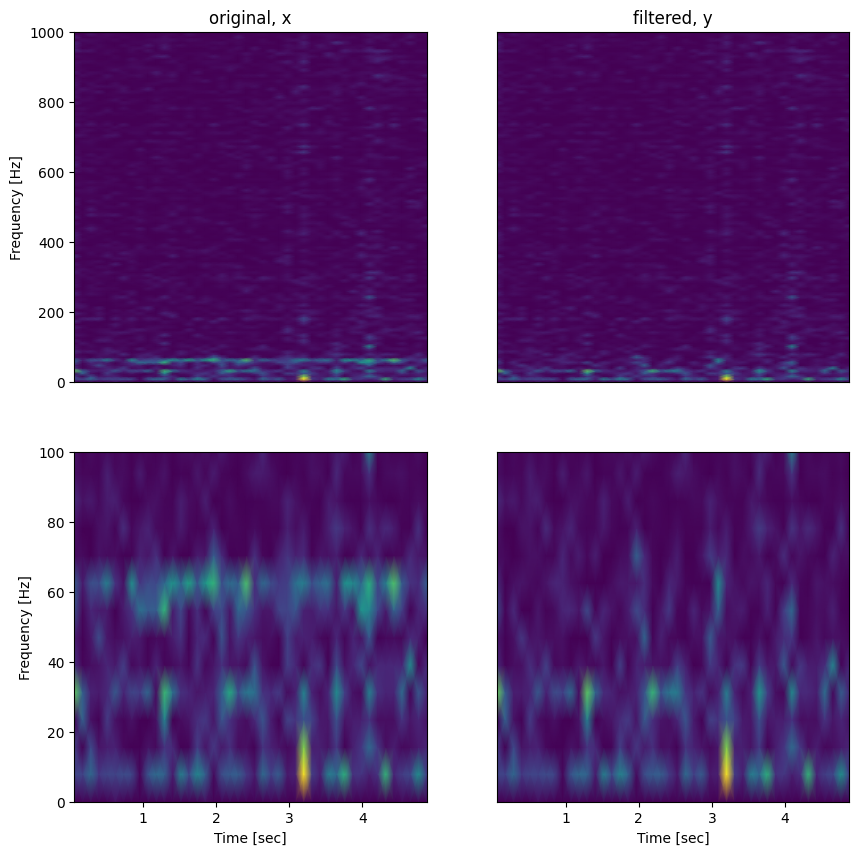

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
f, t_s, Sxx = signal.spectrogram(x, fs)
plt.title('original, x')
plt.pcolormesh(t_s, f, Sxx, shading='gouraud')
plt.xticks([])
plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')

plt.subplot(2, 2, 2)
f, t_s, Sxx = signal.spectrogram(y, fs)
plt.title('filtered, y')
plt.pcolormesh(t_s, f, Sxx, shading='gouraud')
# plt.ylabel('Frequency [Hz]')
plt.xticks([])
plt.yticks([])
# plt.xlabel('Time [sec]')

# plt.show()

# zoom in on 60Hz...

# plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 3)
f, t_s, Sxx = signal.spectrogram(x, fs)
# plt.title('original, x')
plt.pcolormesh(t_s, f, Sxx, shading='gouraud')
plt.ylim(0, 100)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(2, 2, 4)
f, t_s, Sxx = signal.spectrogram(y, fs)
# plt.title('filtered, y')
plt.pcolormesh(t_s, f, Sxx, shading='gouraud')
# plt.ylabel('Frequency [Hz]')
plt.ylim(0, 100)
plt.yticks([])
plt.xlabel('t [s]')

plt.show()

# Gain, phase, IR

In [ ]:
H = np.fft.fft(h)
gain = np.abs(H)
# matlab angle(): radians -> degrees
phasedelay = np.angle(H) * 180 / np.pi

k = np.arange(N)
fbin = k * fs / N

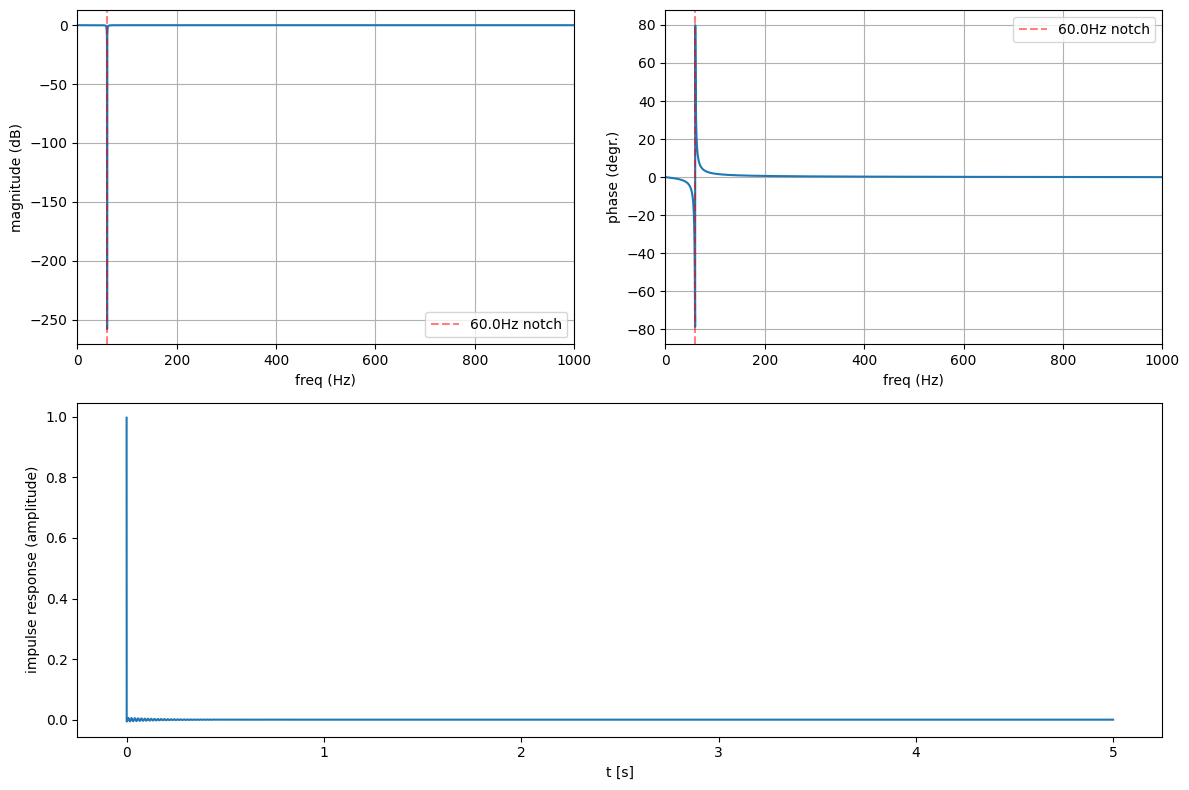

In [ ]:
plt.figure(figsize=(12,8))

ax1 = plt.subplot(2, 2, 1) # magnitude
ax2 = plt.subplot(2, 2, 2) # phase
ax3 = plt.subplot(2, 1, 2) # impulse response

# subplot(2,2,3); plot(fbin, db(Gain)); xlabel('Frequency (Hz)'); grid on; xlim([0 fs/2])
# MATLAB db(x) = 20*log10(x)
ax1.plot(fbin, 20 * np.log10(gain))
ax1.axvline(x=f0, ls='--', c='red', alpha=0.5, label=f'{f0}Hz notch')
ax1.set_xlabel('freq (Hz)')
ax1.set_ylabel('magnitude (dB)')
ax1.grid(True)
ax1.set_xlim(0, fs / 2) # limit at Nyquist
ax1.legend()

# subplot(2,2,4); plot(fbin, Phasedelay); xlabel('Frequency (Hz)'); grid on; xlim([0 fs/2])
ax2.plot(fbin, phasedelay)
ax2.axvline(x=f0, ls='--', c='red', alpha=0.5, label=f'{f0}Hz notch')
ax2.set_xlabel('freq (Hz)')
ax2.set_ylabel('phase (degr.)')
ax2.grid(True)
ax2.set_xlim(0, fs / 2) # limit to Nyquist
ax2.legend()

ax3.plot(t,h)
ax3.set_xlabel('t [s]')
ax3.set_ylabel('impulse response (amplitude)')
# plt.yscale('log')
plt.tight_layout()
plt.show()